## Project Overview

The primary objective of this project is to employ deep learning techniques to train a Computer Vision model specialized in object detection, such that the model is working effectivelly in urban environment, with a focus on aiding autonomous vehicles in detecting and identifying objects.

For achieving the main task, the following subtasks must be done:

- Choosing dataset, which is suitable for object detection model training in urban environment.
- Description and vizualization of the chosen dataset.
- Preprocessing the dataset in order to improve training of the deep learning model.
- Choosing the deep leagning approach for the model training.
- Compare results of the trained model with reference benchmark.
- Visualize you result on the video/gif.

## Set up

Before moving to the main part, we need to execute the following steps:

#### 1. Install dependencies: python packages

In [ ]:
!pip install -r requirements.txt

#### 2. Import all python packages/functions

In [4]:
import os
import fiftyone
import json
import os
import shutil
from ultralytics import YOLO
from ultralytics.data.converter import convert_coco
import torch
import matplotlib.pyplot as plt

## Dataset

#### 1. Description

Our Group decided to take COCO dataset (Common Objects in Context), which is widely known in Computer Vision community and often used as benchmark for computer vision models. It is comprised of a large collection of images that depict complex scenes with multiple objects in various contexts. The COCO dataset is particularly notable for its diversity, containing images captured in everyday settings such as streets, parks, and outdoor environments. This is perfectly suitable for our main goal: detecting objects in urban environment.

**COCO dataset version:**

- We will use the 2017 version.

**COCO dataset image list structure:**
- id – A unique identifier for the image. The id field maps to the id field in the annotations array (where bounding box information is stored).
- license – Maps to the license array.
- coco_url – The location of the image.
- flickr_url – The location of the image on Flickr.
- width – the width of the image.
- height – The height of the image.
- file_name – The image file name. In this example, file_name and id match, but this is not a requirement for COCO datasets.
- date_captured – the date and time the image was captured.

For our purpose we will need only id, width, height, file_name

**COCO dataset structure of the labels:**
- id – The identifier for the annotation.
- image_id – Corresponds to the image id in the images array.
- category_id – The identifier for the label that identifies the object within a bounding box. It maps to the id field of the categories array.
- iscrowd – Specifies if the image contains a crowd of objects.
- segmentation – Segmentation information for objects on an image. Amazon Rekognition Custom Labels doesn't support segmentation.
- area – The area of the annotation.
- bbox – Contains the coordinates, in pixels, of a bounding box around an object on the image.

For our purposes we will need only image_id, category_id and bbox

**COCO dataset category list structure:**
- upercategory – The parent category for a label.
- id – The label identifier. The id field maps to the category_id field in an annotation object. 
- name – the label name.

For our purposes we need only id and name.

**Dataset classes:**

Dataset itself is quite big and it has 80 categories, but we don't need them all for our task. We decided to use only images, which could be useful for urban object detection, hence we downloaded only images, which contain the following objects:
 - person
 - bicycle
 - car
 - motorcycle
 - airplane
 - bus
 - train
 - truck
 - boat
 - traffic light
 - fire hydrant
 - stop sign
 - parking meter
 - bench
 - bird
 - cat
 - dog
 - horse



#### 2. Load data

We will use **fiftyone** library (https://docs.voxel51.com/user_guide/index.html) for download of the COCO dataset, which is a recommended way by COCO dataset maintainers. We will download **train** and **validation** splits, which contains 84k and 3.5k images respectively.

After the execution of the function, the folder structre has the following hierarchy:

- dataset
    - raw
        - json_file_1.json
        - json_file_2.json
    - train
        - data
            - image01_train.jpg
            - image02_train.jpg
            - ... 
        - labels.json
    - validation
        - data
            - image01_val.jpg
            - image02_val.jpg
            - ... 
        - labels.json


where **labels.json** files contains information about labels of the images. For out purposes we need only **train** and **validation** folders and we can neglect **raw** folder.


In [11]:
categories = ["person","bicycle","car","motorcycle", "airplane","bus","train","truck","boat","traffic light","fire hydrant","stop sign","parking meter","bench","bird","cat","dog","horse"]

# Load Training dataset
dataset = fiftyone.zoo.load_zoo_dataset(
    "coco-2017",
    splits=["train",'validation'],
    label_types="detections",
    only_matching=True,
    classes=categories,
    dataset_dir = './dataset'
    )


 100% |██████|    1.9Gb/1.9Gb [16.5s elapsed, 0s remaining, 114.7Mb/s]      
Extracting annotations to '/Users/daniil.yefimov/Desktop/GitHub/Autonomous-Vehicle/dataset/raw/instances_train2017.json'
 100% |██████████████| 84853/84853 [1.0h elapsed, 0s remaining, 20.2 images/s]      
Writing annotations for 84853 downloaded samples to '/Users/daniil.yefimov/Desktop/GitHub/Autonomous-Vehicle/dataset/train/labels.json'
Found annotations at '/Users/daniil.yefimov/Desktop/GitHub/Autonomous-Vehicle/dataset/raw/instances_val2017.json'
 100% |████████████████| 3574/3574 [2.7m elapsed, 0s remaining, 20.1 images/s]      
Writing annotations for 3574 downloaded samples to '/Users/daniil.yefimov/Desktop/GitHub/Autonomous-Vehicle/dataset/validation/labels.json'
Dataset info written to '/Users/daniil.yefimov/Desktop/GitHub/Autonomous-Vehicle/dataset/info.json'
Loading 'coco-2017' split 'train'
 100% |█████████████| 84853/84853 [5.8m elapsed, 0s remaining, 241.2 samples/s]      
Loading 'coco-2017' sp

'\ndataset_train.export(\n    export_dir="/Users/daniil.yefimov/Desktop/GitHub/Autonomous-Vehicle/dataset/train",\n    dataset_type=fiftyone.types.COCODetectionDataset,\n    label_field="ground_truth"\n)\n'

#### 3. Bring Data into YOLO format:

Before this step our data are in COCO format (see description above). In order to use the YOLO deep learning algorithm (will be discussed in the next section), we need to bring it into the correct YOLO format, which has the followinhg structure:

- one *.txt file per image.
- The *.txt file should be formatted with one row per object in [class x_center y_center width height] format (COCO format has [x_min, y_min, width, height] format )
- Box coordinates must be in normalized xywh format (from 0 to 1).
- Class numbers should be zero-indexed (COCO start with 1).

For this transformation we will use **convert_coco** function from ultralytics (maintainers of YOLO).

After this transformation the folder structrue has the following hierarchy:

- dataset
    - raw
        - json_file_1.json
        - json_file_2.json
    - train
        - images
            - image01_train.jpg
            - image02_train.jpg
            - ... 
        - labels
            - image01_label.txt
            - image02_label.txt
            - ... 
    - validation
        - data
            - image01_val.jpg
            - image02_val.jpg
            - ... 
        - labels
            - image01_label.txt
            - image02_label.txt
            - ...


In [ ]:
# Define pathes
input_path = './dataset'

#train yolo format
convert_coco(labels_dir= os.path.join(input_path,'train'),save_dir = './converter_result')
shutil.move('./converter_result/labels/labels', os.path.join(input_path,'train/labels'))
shutil.rmtree('./converter_result')
os.rename(os.path.join(input_path,'train/data'), os.path.join(input_path,'train/images'))


#validation yolo format
convert_coco(labels_dir=os.path.join(input_path,'validation'),save_dir = './converter_result')
shutil.move('./converter_result/labels/labels', os.path.join(input_path,'validation/labels'))
shutil.rmtree('./converter_result')
os.rename(os.path.join(input_path,'validation/data'), os.path.join(input_path,'validation/images'))


In [3]:
# Utilities

# Read Json file
def read_json_file(path):
    f = open(path)
    data = json.load(f)
    f.close()
    return data

# Function to count occurrences of category_id numbers in the list
def count_category_ids(data_list):
    occurrences = {}

    # Iterate over each dictionary in the list
    for data in data_list:
        category_id = data.get('category_id') - 1
        # Count occurrences of the category_id
        if category_id in occurrences:
            occurrences[category_id] += 1
        else:
            occurrences[category_id] = 1
    
    return occurrences

# Load Json anotation: dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
train_labels = read_json_file(os.path.join(input_path,'train/labels.json'))
val_labels = read_json_file(os.path.join(input_path,'validation/labels.json'))

# Count occurrences of category_id in both datasets
train_labels_counts = count_category_ids(train_labels['annotations'])
train_labels_counts = dict(sorted(train_labels_counts.items(), key=lambda x: x[0]))

val_labels_counts = count_category_ids(val_labels['annotations'])
val_labels_counts = dict(sorted(val_labels_counts.items(), key=lambda x: x[0]))


# categories
categories_labels = train_labels['categories'][:]

# Decrease each "id" by 1
for item in categories_labels:
    item['id'] -= 1


# labels selected by group
main_categories_labels = [record for record in categories_labels if record['name'] in categories]

In [64]:
main_categories_labels 

[{'supercategory': 'person', 'id': 0, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 1, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 9, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 12, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 15, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 16, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 17, 'name': 'dog'},


#### 4. Dataset Analysis

**dataset sizes**

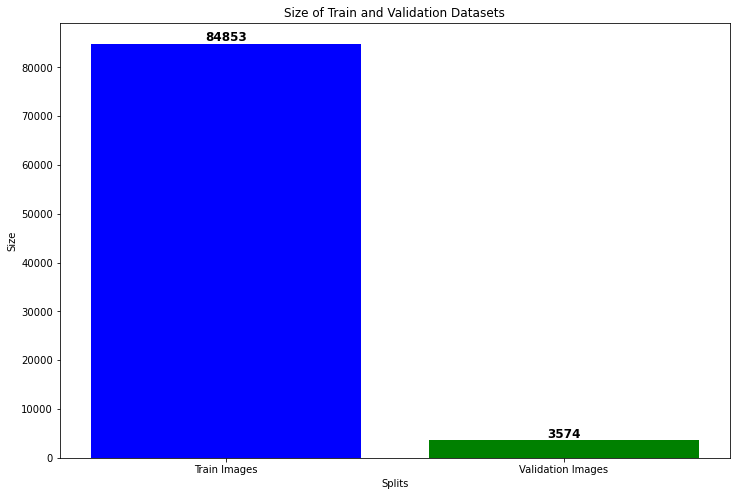

In [17]:
import os
import matplotlib.pyplot as plt


train_set_size = len(os.listdir(os.path.join(input_path,'train/images')))
val_set_size = len(os.listdir(os.path.join(input_path,'validation/images')))

# Plotting the bar graph
folders = ['Train Images', 'Validation Images']
sizes = [train_set_size, val_set_size]

plt.figure(figsize=(12, 8)) 
bars = plt.bar(folders, sizes, color=['blue', 'green'])
plt.xlabel('Splits')
plt.ylabel('Size')
plt.title('Size of Train and Validation Datasets')
for bar, size in zip(bars, sizes):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             f'{size}', 
             ha='center', 
             va='bottom',
             fontsize=12,   # Adjust font size
             fontweight='bold')

plt.show()



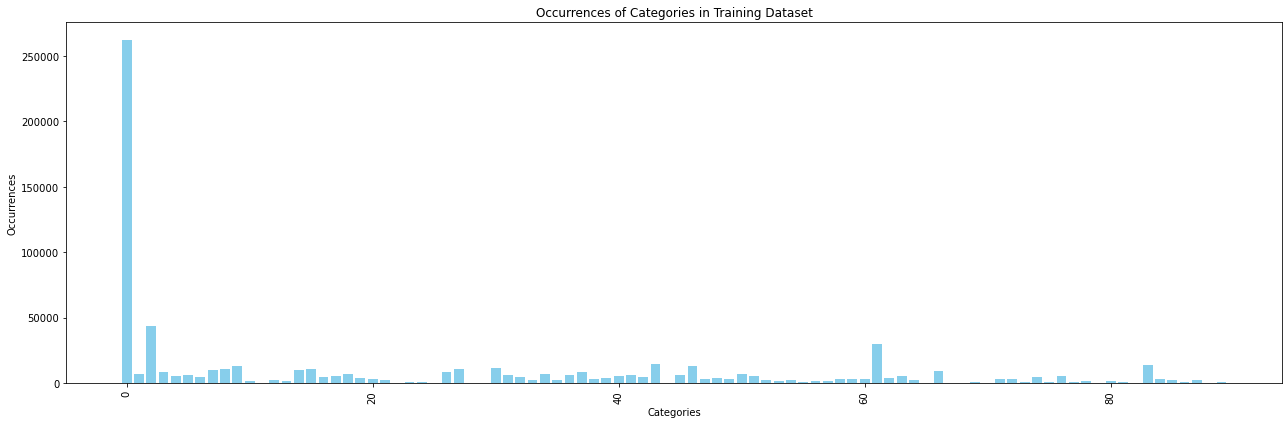

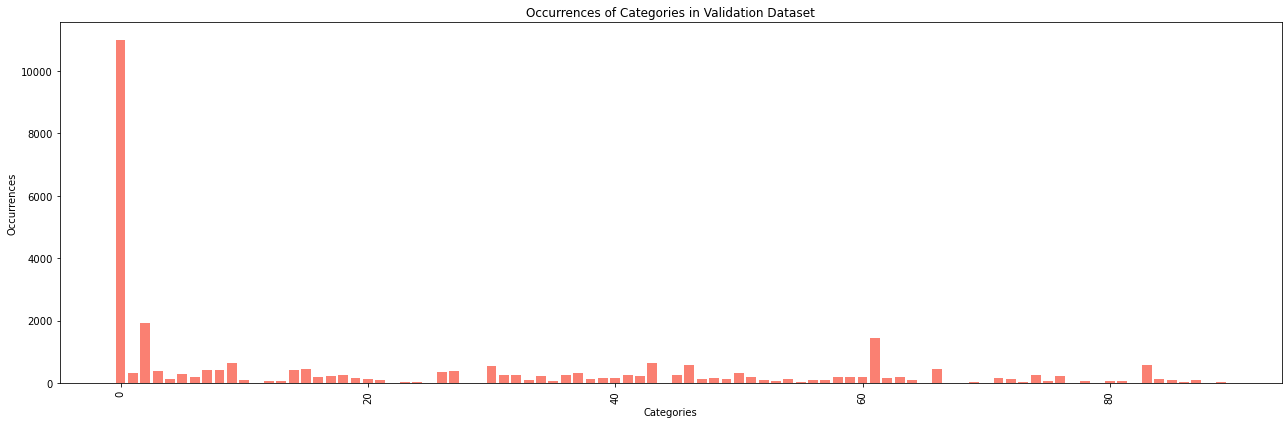

In [36]:
import matplotlib.pyplot as plt

# Example dictionaries containing category occurrences for training and validation datasets

# Extract category names and occurrences for training data
categories_training = list(train_labels_counts.keys())
training_counts = list(train_labels_counts.values())

# Plot for training data
plt.figure(figsize=(18, 6))
plt.bar(categories_training, training_counts, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Occurrences')
plt.title('Occurrences of Categories in Training Dataset')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Extract category names and occurrences for validation data

categories_validation = list(train_labels_counts.keys())
validation_counts = list(val_labels_counts.values())

# Plot for validation data
plt.figure(figsize=(18, 6))
plt.bar(categories_validation, validation_counts, color='salmon')
plt.xlabel('Categories')
plt.ylabel('Occurrences')
plt.title('Occurrences of Categories in Validation Dataset')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [60]:
categories_training

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 26,
 27,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 66,
 69,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 83,
 84,
 85,
 86,
 87,
 88,
 89]

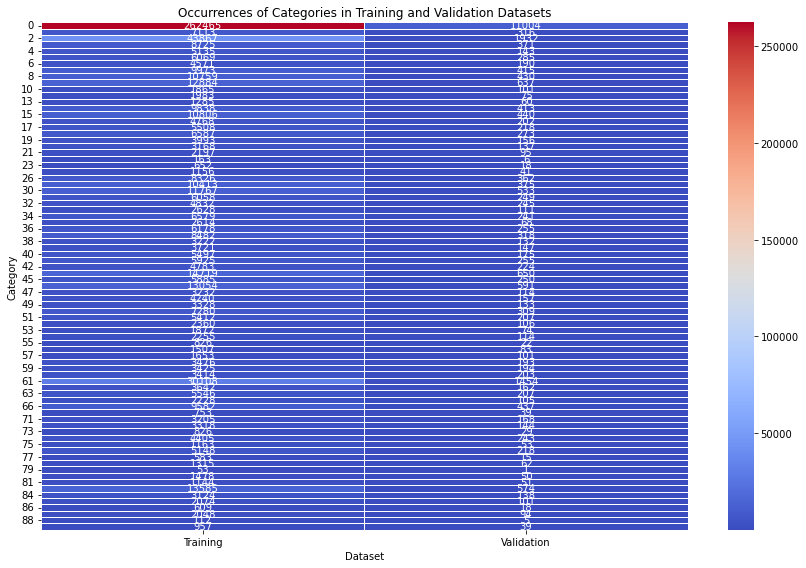

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example dictionaries containing category occurrences for training and validation datasets



categories_training = list(train_labels_counts.keys())
training_counts = list(train_labels_counts.values())

categories_validation = list(train_labels_counts.keys())
validation_counts = list(val_labels_counts.values())

# Create a dataframe for training data
training_df = pd.DataFrame({'Category': categories_training, 'Count_Training': training_counts})

# Create a dataframe for validation data
validation_df = pd.DataFrame({'Category': categories_validation, 'Count_Validation': validation_counts})

# Merge the dataframes
merged_df = training_df.merge(validation_df, on='Category', how='outer')

# Fill NaN values with 0
merged_df.fillna(0, inplace=True)

# Create the pivot table
pivot_df = merged_df.pivot_table(index='Category', values=['Count_Training', 'Count_Validation'])

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, cmap='coolwarm', annot=True, fmt="d", linewidths=.5)
plt.title('Occurrences of Categories in Training and Validation Datasets')
plt.xlabel('Dataset')
plt.ylabel('Category')
plt.xticks(ticks=[0.5, 1.5], labels=['Training', 'Validation'])
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### 5. Preprocessing

## Training

#### 1. Reference Experiment



In [ ]:
model = YOLO('./model/yolov8n.pt') 
metrics = model.val(data='coco.yaml')

#### 2. Improve on the reference

In [ ]:
model = YOLO('./model/yolov8n.pt')  

# Train the model
results = model.train(data='coco.yaml', epochs=1, imgsz=640)

# inference 

model = YOLO('./model/yolov8n.pt') 
metrics = model.val(data='coco.yaml')

## Experiment

In [27]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class YOLODataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_folder = os.path.join(root_dir, "images")
        self.label_folder = os.path.join(root_dir, "labels")
        self.image_filenames = os.listdir(self.image_folder)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_filenames[idx])
        label_name = os.path.join(self.label_folder, self.image_filenames[idx].replace(".jpg", ".txt"))

        image = Image.open(img_name).convert("RGB")
        
       # Load labels
        with open(label_name, "r") as file:
            labels = file.readlines()
        
        targets = []
        for label in labels:
            # Parse label: x_center, y_center, width, height, class_id
            label_parts = label.strip().split()
            class_id = int(label_parts[0])
            x_center = float(label_parts[1])
            y_center = float(label_parts[2])
            width = float(label_parts[3])
            height = float(label_parts[4])

            targets.append([x_center, y_center, width, height,class_id])

        # Convert to PyTorch tensor
        targets = torch.tensor(targets)

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
        
        return image, targets

# Define transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Define paths to train and validation datasets
train_dataset = YOLODataset(root_dir='./dataset/train', transform=transform)
val_dataset = YOLODataset(root_dir='./dataset/validation', transform=transform)

# Create DataLoader objects for train and validation datasets
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


In [2]:
from ultralytics import YOLO
model = YOLO('./model/yolov8n.pt') 

In [15]:
from ultralytics.utils.loss import FocalLoss
from  torch.optim import optimizer

# Initialize FocalLoss
criterion = FocalLoss()

# Then, during your training loop replace the default criterion with FocalLoss
for imgs, targets in train_loader:
    # Forward pass
    predictions = model(imgs)
    # Calculate loss using FocalLoss instead of the default one
    loss = criterion(predictions, targets)
    # Backward and optimize
    loss.backward()
    optimizer.step()


0: 256x256 1 bicycle, 1 bench, 30.8ms
Speed: 0.0ms preprocess, 30.8ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


AttributeError: 'list' object has no attribute 'size'

In [22]:
for result in predictions:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    result.show()  # display to screen

In [16]:
boxes = predictions.boxes
probs = predictions.probs

AttributeError: 'list' object has no attribute 'boxes'

In [32]:
boxes.data/256

tensor([[0.0067, 0.3068, 0.9963, 0.9968, 0.0022, 0.0508],
        [0.0057, 0.3140, 0.9953, 0.9984, 0.0012, 0.0039]])

In [ ]:
boxes.

In [28]:
targets

tensor([[[ 1.0000,  0.5050,  0.7038,  0.9900,  0.5451],
         [13.0000,  0.6103,  0.6420,  0.6327,  0.6831]]])